# Clique partition problem

### Realization

#### Imports

In [1]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#### Functions

In [2]:
class CliquePartitionSolver:
    def __init__(self):
        self.solver = None
        self.problem = None
        
    def solve_with_adjacency_matrix(self, adj_matrix):
        """
        Реализация clique partition problem (матрица смежности)
        """
        n = len(adj_matrix)
        
        self.problem = pulp.LpProblem("Clique_Partition", pulp.LpMinimize)
        
        y = [pulp.LpVariable(f"y_{i}", cat='Binary') for i in range(n)]
        x = [[pulp.LpVariable(f"x_{i}_{j}", cat='Binary') for j in range(n)] 
             for i in range(n)]
        
        self.problem += pulp.lpSum(y), "Minimize_Number_of_Cliques"
        
        for j in range(n):
            self.problem += (pulp.lpSum(x[i][j] for i in range(n)) == 1, 
                           f"Vertex_{j}_Assignment")
        
        for i in range(n):
            for j in range(n):
                self.problem += (x[i][j] <= y[i], 
                               f"Clique_Usage_{i}_{j}")
        
        for i in range(n):
            for u in range(n):
                for v in range(u + 1, n):
                    if adj_matrix[u][v] == 0:
                        self.problem += (x[i][u] + x[i][v] <= 1,
                                       f"Non_Edge_Constraint_{i}_{u}_{v}")
        
        self.problem.solve(pulp.PULP_CBC_CMD(msg=False))
        
        if self.problem.status == pulp.LpStatusOptimal:
            return self.extract_solution(n, y, x, adj_matrix)
        else:
            raise Exception("Оптимальное решение не найдено")
    
    def solve_with_graph(self, graph):
        """
        Реализация clique partition problem в случае графа из библиотеки
        """
        n = len(graph.nodes())
        adj_matrix = np.zeros((n, n), dtype=int)
        
        node_list = list(graph.nodes())
        node_to_index = {node: idx for idx, node in enumerate(node_list)}
        
        for u, v in graph.edges():
            i, j = node_to_index[u], node_to_index[v]
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
        
        result = self.solve_with_adjacency_matrix(adj_matrix)
        
        result['cliques'] = [
            [node_list[idx] for idx in clique] 
            for clique in result['cliques']
        ]
        
        return result
    
    def extract_solution(self, n, y, x, adj_matrix):
        """
        Извлекаем решение
        """
        cliques = []
        
        for i in range(n):
            if pulp.value(y[i]) > 0.5:
                clique = []
                for j in range(n):
                    if pulp.value(x[i][j]) > 0.5:
                        clique.append(j)
                if clique:
                    cliques.append(clique)
        
        return {
            'number_of_cliques': len(cliques),
            'cliques': cliques,
            'objective_value': pulp.value(self.problem.objective),
            'status': pulp.LpStatus[self.problem.status]
        }   

In [3]:
def create_test_graph():
    """
    Создаем граф
    """
    G = nx.Graph()
    edges = [
        (0, 1), (0, 2), (1, 2),  # Треугольник
        (2, 3), (2, 4), 
        (3, 4), (3, 5), (4, 5),  # Другой треугольник
        (5, 6), (6, 7), (7, 8), (8, 5)  # Цикл
    ]
    G.add_edges_from(edges)
    return G

def print_graph_info(graph):
    print("Информация по исходному графу:")
    print(f"Вершины: {list(graph.nodes())}")
    print(f"Рёбра: {list(graph.edges())}")
    print(f"Степени вершин:")
    for node in graph.nodes():
        print(f"  Вершина {node}: степень {graph.degree[node]}")
    print()

def print_cliques_result(result):
    print("Результат разбиения на клики:")
    print(f"Количество клик: {result['number_of_cliques']}")
    for i, clique in enumerate(result['cliques'], 1):
        print(f"Клика {i}: {clique}")

def visualize_graph_and_cliques(graph, result):
    """
    Сгенирированая визуализация
    """
    # Создаем фигуру с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Общая позиция для обоих графиков
    pos = nx.spring_layout(graph, seed=42)
    
    # Первый график: исходный граф
    nx.draw_networkx_nodes(graph, pos, ax=ax1, node_color='lightblue', 
                          node_size=500, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, ax=ax1, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, ax=ax1, font_size=12)
    ax1.set_title("Исходный граф", fontsize=14)
    ax1.axis('off')
    
    # Второй график: граф с раскраской по кликам
    # Создаем раскраску вершин по кликам
    node_colors = []
    color_map = plt.cm.Set3
    node_list = list(graph.nodes())
    
    # Назначаем цвета вершинам
    for node in node_list:
        for idx, clique in enumerate(result['cliques']):
            if node in clique:
                node_colors.append(idx)
                break
    
    nx.draw_networkx_nodes(graph, pos, ax=ax2, node_color=node_colors, 
                          cmap=color_map, node_size=500, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, ax=ax2, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, ax=ax2, font_size=12)
    ax2.set_title(f"Разбиение на клики (всего: {result['number_of_cliques']})", fontsize=14)
    ax2.axis('off')
    
    # Добавляем легенду для клик
    legend_elements = []
    for idx, clique in enumerate(result['cliques']):
        legend_elements.append(plt.Line2D([0], [0], 
                                        marker='o', 
                                        color='w', 
                                        markerfacecolor=color_map(idx / len(result['cliques'])),
                                        markersize=10,
                                        label=f'Клика {idx+1}: {clique}'))
    
    ax2.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

#### Case

Информация по исходному графу:
Вершины: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Рёбра: [(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (5, 6), (5, 8), (6, 7), (7, 8)]
Степени вершин:
  Вершина 0: степень 2
  Вершина 1: степень 2
  Вершина 2: степень 4
  Вершина 3: степень 3
  Вершина 4: степень 3
  Вершина 5: степень 4
  Вершина 6: степень 2
  Вершина 7: степень 2
  Вершина 8: степень 2

Результат разбиения на клики:
Количество клик: 4
Клика 1: [3, 4, 5]
Клика 2: [0, 1, 2]
Клика 3: [6]
Клика 4: [7, 8]


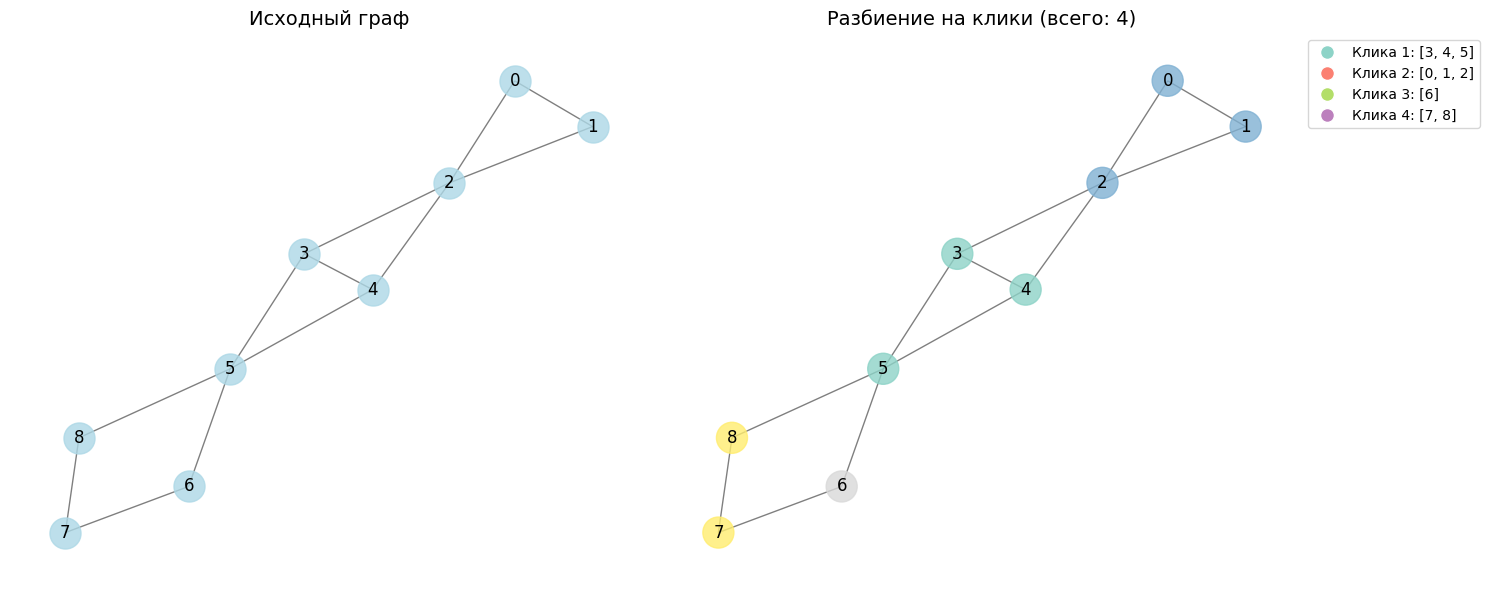

In [4]:
solver = CliquePartitionSolver()
G = create_test_graph()
    
print_graph_info(G)
result = solver.solve_with_graph(G)
print_cliques_result(result)
    
visualize_graph_and_cliques(G, result)